## CSE3502 Information Security Management


## Embedded Project

## Hasnain Sikora 19BAI1072

# Training an Intrusion Detection System with KDD99

The [KDD-99 dataset](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) is very famous in the security field and almost a "hello world" of Intrusion Detection Systems (IDS) in machine learning. An intrusion detection system (IDS) is program that monitors computers and network systems for malicious activity or policy violations. Any intrusion activity or violation is typically reported either to an administrator or collected centrally. IDS types range in scope from single computers to large networks. Although KDD99 dataset is over 20 years old, it is still widely used to demonstrate Intrusion Detection Systems (IDS). KDD99 is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. This database contains a standard set of data to be audited, including a wide variety of intrusions simulated in a military network environment.


### Import in Raw KDD-99 Dataset

The following code reads the KDD99 CSV dataset into a Pandas data frame. The standard format of KDD99 does not include column names. Because of that, the program adds them.

* In this step we select and discover the data that was processed and will be used to train our machine learning model.

* The dataset consists of a wide variety of intrusions simulated in a military network environment. It has 494021 rows & 42 columns.

* This file is a CSV, just no CSV extension or headers Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

* For handling the missing values, just drop NA's (rows with missing values)

In [1]:
import pandas as pd
from tensorflow.keras.utils import get_file

try:
    path = get_file('kddcup.data_10_percent.gz', origin=
    'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise
    
print(path) 


df = pd.read_csv(path, header=None)

print("Read {} rows.".format(len(df)))

# To make our work faster we may even sample only a small portion of the dataset
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to 
# sample only 10% of the dataset

df.dropna(inplace=True,axis=1) 
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

pd.set_option('display.max_columns', 5)
pd.set_option('display.max_rows', 5)
# display 5 rows
display(df[0:5])

Init Plugin
Init Graph Optimizer
Init Kernel
/Users/rsaraf/.keras/datasets/kddcup.data_10_percent.gz
Read 494021 rows.


,duration,protocol_type,...,dst_host_srv_rerror_rate,outcome
0,0,tcp,...,0.0,normal.
1,0,tcp,...,0.0,normal.
2,0,tcp,...,0.0,normal.
3,0,tcp,...,0.0,normal.
4,0,tcp,...,0.0,normal.


### Analyzing the Dataset

Before we preprocess the KDD99 dataset let's have a look at the individual columns and distributions. 


The following script gives a high level overview of how the dataset appears.

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def perform_analysis(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,\
                int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

The analysis looks at how many unique values are present.  For example, duration, which is a numeric value, has 2495 unique values, and there is a 0% overlap.  A text/categorical value such as protocol_type only has a few unique values, and the program shows the percentages of each.  Columns with a large number of unique values do not have their item counts shown to save display space.

In [3]:
# Analyze KDD-99
perform_analysis(df)


494021 rows
** duration:2495 (0%)
** protocol_type:[icmp:57.41%,tcp:38.47%,udp:4.12%]
** service:[ecr_i:56.96%,private:22.45%,http:13.01%,smtp:1.97%,other:1.46%,domain_u:1.19%,ftp_data:0.96%,eco_i:0.33%,ftp:0.16%,finger:0.14%,urp_i:0.11%,telnet:0.1%,ntp_u:0.08%,auth:0.07%,pop_3:0.04%,time:0.03%,csnet_ns:0.03%,remote_job:0.02%,gopher:0.02%,imap4:0.02%,discard:0.02%,domain:0.02%,iso_tsap:0.02%,systat:0.02%,shell:0.02%,echo:0.02%,rje:0.02%,whois:0.02%,sql_net:0.02%,printer:0.02%,nntp:0.02%,courier:0.02%,sunrpc:0.02%,netbios_ssn:0.02%,mtp:0.02%,vmnet:0.02%,uucp_path:0.02%,uucp:0.02%,klogin:0.02%,bgp:0.02%,ssh:0.02%,supdup:0.02%,nnsp:0.02%,login:0.02%,hostnames:0.02%,efs:0.02%,daytime:0.02%,link:0.02%,netbios_ns:0.02%,pop_2:0.02%,ldap:0.02%,netbios_dgm:0.02%,exec:0.02%,http_443:0.02%,kshell:0.02%,name:0.02%,ctf:0.02%,netstat:0.02%,Z39_50:0.02%,IRC:0.01%,urh_i:0.0%,X11:0.0%,tim_i:0.0%,pm_dump:0.0%,tftp_u:0.0%,red_i:0.0%]
** flag:[SF:76.6%,S0:17.61%,REJ:5.44%,RSTR:0.18%,RSTO:0.12%,SH:0.02%,S

### Encode the feature vector


We use the two functions written below to preprocess and encode the data so that it usable for machine learning tasks. The first encodes Z-Scores, and the second creates dummy variables from categorical columns.

In [4]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],
# [0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


We convert all numeric values to Z-Score, and we translate all categorical to dummy variables. We preprocess the dataset and encode the feature vector



In [5]:
encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]
# This is the numeric feature vector, as it goes to the neural net


# Convert to numpy - Classification
x_columns = df.columns.drop('outcome')
x = df[x_columns].values
dummies = pd.get_dummies(df['outcome']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

In [ ]:
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.countplot(y)

We will attempt to predict what type of attack is underway.  The outcome column specifies the attack type.  A value of normal indicates that there is no attack underway.  We display the outcomes; some attack types are much rarer than others.

In [6]:
df.groupby('outcome')['outcome'].count()

outcome
back.               2203
buffer_overflow.      30
                    ... 
warezclient.        1020
warezmaster.          20
Name: outcome, Length: 23, dtype: int64

## The Genetic Algorithm

The genetic algorithm is a method for solving both constrained and unconstrained optimization problems that is based on natural selection, the process that drives biological evolution. The genetic algorithm repeatedly modifies a population of individual solutions. At each step, the genetic algorithm selects individuals from the current population to be parents and uses them to produce the children for the next generation. Over successive generations, the population "evolves" toward an optimal solution. This algorithm can be used for a variety of optimization problems, and hence we also attempt to optimize our Intrusion Detection System using this.

## Importing PyGAD 

PyGAD is an open-source Python library for building the genetic algorithm and training machine learning algorithms. It offers a wide range of parameters to customize the genetic algorithm to work with different types of problems.

PyGAD has its own modules that support building and training neural networks (NNs) and convolutional neural networks (CNNs). Despite these modules working well, they are implemented in Python without any additional optimization measures. This leads to comparatively high computational times for even simple problems.

### Fitness for Binary Classification


For a multiple classification problem, below is a fitness function that works with PyGAD. It calculates the categorical cross-entropy loss, assuming that the classification problem is binary.


### Generation Callback Function (Optional)

The generation callback function is implemented below. In PyGAD, this callback function must accept a parameter referring to the instance of the genetic algorithm, by which the current population can be fetched using the population attribute.

This function prints the current generation number and the fitness value of the best solution. Such information keeps the user updated on the progress of the genetic algorithm.

In [7]:
import tensorflow.keras
import pygad.kerasga
import numpy
import pygad

def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, keras_ga, model

    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                 weights_vector=solution)

    model.set_weights(weights=model_weights_matrix)

    predictions = model.predict(data_inputs)

    cce = tensorflow.keras.losses.CategoricalCrossentropy()
    solution_fitness = 1.0 / (cce(data_outputs, predictions).numpy() + 0.00000001)

    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

# Train the Neural Network and optimizing it using Genetic Algorithm

We now train the neural network to classify the different KDD99 outcomes.  The code provided here implements a neural netowrk with two hidden layers.  We train it with the provided KDD99 data.

In [8]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
keras_ga = pygad.kerasga.KerasGA(model=model,
                                 num_solutions=10)

# Data inputs
data_inputs = x_train

# Data outputs
data_outputs = y_train
# data_outputs = tensorflow.keras.utils.to_categorical(data_outputs)

num_generations = 200
num_parents_mating = 5
initial_population = keras_ga.population_weights

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

ga_instance.run()

Metal device set to: Apple M1


2022-04-08 13:00:03.267458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-08 13:00:03.267985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-08 13:00:03.432712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-08 13:00:03.436474: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-08 13:00:03.483457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Generation = 1
Fitness    = 0.31925243308512374
Generation = 2
Fitness    = 0.38172959976441695
Generation = 3
Fitness    = 0.38172959976441695
Generation = 4
Fitness    = 0.38172959976441695
Generation = 5
Fitness    = 0.38352073805420167
Generation = 6
Fitness    = 0.38352073805420167
Generation = 7
Fitness    = 0.4082957247483002
Generation = 8
Fitness    = 0.4082957247483002
Generation = 9
Fitness    = 0.4082957247483002
Generation = 10
Fitness    = 0.4526498256242198
Generation = 11
Fitness    = 0.4526498256242198
Generation = 12
Fitness    = 0.4526498256242198
Generation = 13
Fitness    = 0.4526498256242198
Generation = 14
Fitness    = 0.5751283353555116
Generation = 15
Fitness    = 0.5751283353555116
Generation = 16
Fitness    = 0.8434771433298451
Generation = 17
Fitness    = 0.8434771433298451
Generation = 18
Fitness    = 0.8434771433298451
Generation = 19
Fitness    = 0.8434771433298451
Generation = 20
Fitness    = 0.8434771433298451
Generation = 21
Fitness    = 0.843477143329

Generation = 171
Fitness    = 1.6301096558452997
Generation = 172
Fitness    = 1.6301096558452997
Generation = 173
Fitness    = 1.6301096558452997
Generation = 174
Fitness    = 1.6579570660003065
Generation = 175
Fitness    = 1.6579570660003065
Generation = 176
Fitness    = 1.6579570660003065
Generation = 177
Fitness    = 1.6579570660003065
Generation = 178
Fitness    = 1.6579570660003065
Generation = 179
Fitness    = 1.8061210641027656
Generation = 180
Fitness    = 1.8061210641027656
Generation = 181
Fitness    = 1.8061210641027656
Generation = 182
Fitness    = 1.8061210641027656
Generation = 183
Fitness    = 1.8061210641027656
Generation = 184
Fitness    = 1.8061210641027656
Generation = 185
Fitness    = 1.8061210641027656
Generation = 186
Fitness    = 1.8061210641027656
Generation = 187
Fitness    = 1.8061210641027656
Generation = 188
Fitness    = 1.8061210641027656
Generation = 189
Fitness    = 1.8061210641027656
Generation = 190
Fitness    = 1.8061210641027656
Generation = 191
Fit

We can now evaluate the neural network.  As you can see, the neural network achieves a 99% accuracy rate.

The following plot shows how the fitness value evolves per generation. As long as the fitness value increases, you can increase the number of generations to achieve better accuracy.

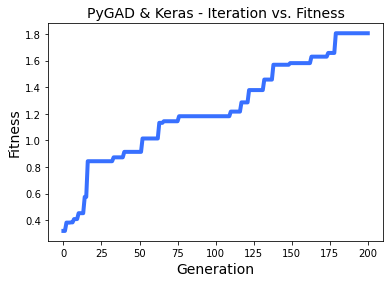

Fitness value of the best solution = 1.8061210641027656
Index of the best solution : 0
Predictions : 
 [[1.4908887e-08 4.8765558e-34 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 2.4388744e-09]
 [1.8692126e-16 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 3.8315056e-18]
 [6.5608442e-02 7.3184879e-03 1.0687986e-03 ... 1.5702480e-04
  2.2373352e-07 9.3409337e-02]
 ...
 [1.4887444e-08 4.8486194e-34 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 2.4349582e-09]
 [4.2243078e-02 2.6504927e-06 4.6329179e-10 ... 2.2918820e-12
  7.7553562e-24 4.5154881e-02]
 [6.5640241e-02 7.2785406e-03 1.0572858e-03 ... 1.5491458e-04
  2.1726402e-07 9.3433321e-02]]
Categorical Crossentropy :  0.55367273
Accuracy :  0.86894995


In [13]:
ga_instance.plot_result(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)
model.set_weights(best_solution_weights)
predictions = model.predict(data_inputs)
print("Predictions : \n", predictions)

# Calculate the categorical crossentropy for the trained model.
cce = tensorflow.keras.losses.CategoricalCrossentropy()
print("Categorical Crossentropy : ", cce(data_outputs, predictions).numpy())

# Calculate the classification accuracy for the trained model.
ca = tensorflow.keras.metrics.CategoricalAccuracy()
ca.update_state(data_outputs, predictions)
accuracy = ca.result().numpy()
print("Accuracy : ", accuracy)